In [1]:
# default libs
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# vector geo data libs
import pandas as pd
import geopandas as gpd
import contextily as cx
pd.options.mode.copy_on_write = True
pd.set_option('display.max_columns', 500)
# kriging
from pykrige.rk import RegressionKriging
import pykrige.kriging_tools as kt
# sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from itertools import product
import re


In [5]:
df = gpd.read_file('..\\output\\final_data_nodes.GEOJSON')

In [30]:
df

,level_0,index,y,x,dBA_rivm,no_observations,speed,speed_slt30,dBA_raw,dBA_raw_slt30,dBA_noise_red,dBA_noise_red_slt30,dBA_reg_adj,dBA_reg_adj_slt30,dBA_dual_red,dBA_dual_red_slt30,maxspeed,bridge,junction,rt_highway,rt_trunk,rt_primary,rt_secondary,rt_tertiary,rt_unclassified,rt_residential,rt_living_street,rt_busway,rt_service,sub_area,dist_to_train,dist_to_recreation,landuse_is_residential,landuse_is_commercial,landuse_is_industrial,building_height,geometry,fold,xf
0,0,12977,459695.0,133925.0,57,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50,False,False,False,False,False,False,False,True,False,False,False,False,Overvecht,1300.784441,424.671643,False,False,False,0.00,POINT (133925.000 459695.000),0,0
1,1,12934,459705.0,133925.0,62,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50,False,False,False,False,False,False,False,True,False,False,False,False,Overvecht,1308.078918,419.220086,False,False,False,0.00,POINT (133925.000 459705.000),0,0
2,2,13013,459685.0,133935.0,53,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50,False,False,False,False,False,False,False,True,False,False,False,False,Overvecht,1300.355718,438.543805,False,False,False,0.00,POINT (133935.000 459685.000),0,0
3,3,12978,459695.0,133935.0,56,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50,False,False,False,False,False,False,False,True,False,False,False,False,Overvecht,1307.625831,433.035964,False,False,False,0.00,POINT (133935.000 459695.000),0,0
4,4,12935,459705.0,133935.0,60,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50,False,False,False,False,False,False,False,True,False,False,False,False,Overvecht,1314.919284,427.691036,False,False,False,0.00,POINT (133935.000 459705.000),0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14056,14056,7173,455725.0,141345.0,60,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50,False,False,False,False,False,False,False,True,False,False,False,False,Science Park,3404.810745,670.885730,False,False,False,8.62,POINT (141345.000 455725.000),15,3
14057,14057,7212,455715.0,141355.0,60,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50,False,False,False,False,False,False,False,True,False,False,False,False,Science Park,3416.811226,674.397346,False,False,False,0.00,POINT (141355.000 455715.000),15,3
14058,14058,7213,455715.0,141355.0,60,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50,False,False,False,False,False,False,False,True,False,False,False,False,Science Park,3416.811226,674.397346,False,False,False,0.00,POINT (141355.000 455715.000),15,3
14059,14059,7174,455725.0,141355.0,58,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50,False,False,False,False,False,False,False,True,False,False,False,False,Science Park,3414.552273,679.458516,False,False,False,8.62,POINT (141355.000 455725.000),15,3


In [71]:

no_folds = 16
folds_per_axis = int(np.sqrt(no_folds))

def create_fold_arr (sorted_df, no_folds):
    fold_arr = np.concatenate([np.full((sorted_df.shape[0] // no_folds), i) for i in range(no_folds-1)])
    fold_arr = np.concatenate((fold_arr, np.full(sorted_df.shape[0]-len(fold_arr), no_folds-1)))
    return fold_arr

df = df.sort_values(by=['x', 'y']).reset_index(drop=True)
df['xf'] = create_fold_arr(df, folds_per_axis)
df = df.sort_values(by=['xf', 'y']).reset_index(drop=True)
df['fold'] = create_fold_arr(df, no_folds)
# df['yf'] = -1
# for xf in range(folds_per_axis):
#     tdf = df[df['xf'] == xf].sort_values(by=['y', 'x'])
#     fold_arr = create_fold_arr(tdf, folds_per_axis)
#     tdf['yf'] = fold_arr
#     df.loc[df['index'].isin(tdf), 'yf'] = fold_arr
#     print(len(fold_arr))

# df = df.sort_values(by=['y', 'x']).reset_index(drop=True)
# df['yf'] = create_fold_arr(df, folds_per_axis)
# df['fold'] = (df['xf']*folds_per_axis) + df['yf']


In [21]:

no_folds = 16
print(df.shape)
df.shape[0] // no_of_folds

(14061, 36)


878

In [26]:
folds = np.concatenate([np.full((df.shape[0] // no_folds), i) for i in range(no_folds-1)])
folds = np.concatenate((folds, np.full(df.shape[0]-len(folds), no_folds-1)))


14061

In [57]:
df['xf'].value_counts()

xf
3    3516
0    3515
1    3515
2    3515
Name: count, dtype: int64

In [58]:
df['yf'].value_counts()

yf
3    3516
0    3515
1    3515
2    3515
Name: count, dtype: int64

In [72]:
# df['fold'] = df['xf']*folds_per_axis + df['yf']
df['fold'].value_counts()

fold
15    891
0     878
1     878
2     878
3     878
4     878
5     878
6     878
7     878
8     878
9     878
10    878
11    878
12    878
13    878
14    878
Name: count, dtype: int64

In [60]:
df

,level_0,index,y,x,dBA_rivm,no_observations,speed,speed_slt30,dBA_raw,dBA_raw_slt30,dBA_noise_red,dBA_noise_red_slt30,dBA_reg_adj,dBA_reg_adj_slt30,dBA_dual_red,dBA_dual_red_slt30,maxspeed,bridge,junction,rt_highway,rt_trunk,rt_primary,rt_secondary,rt_tertiary,rt_unclassified,rt_residential,rt_living_street,rt_busway,rt_service,sub_area,dist_to_train,dist_to_recreation,landuse_is_residential,landuse_is_commercial,landuse_is_industrial,building_height,geometry,fold,xf,yf
0,3271,6581,452165.0,137315.0,56,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,False,False,False,False,False,False,False,False,False,True,False,False,Lunetten,1614.875405,493.742946,True,False,False,8.630000,POINT (137315.000 452165.000),0,0,0
1,3272,6582,452165.0,137315.0,56,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,False,False,False,False,False,False,False,False,False,True,False,False,Lunetten,1614.875405,493.742946,True,False,False,8.630000,POINT (137315.000 452165.000),0,0,0
2,3338,6583,452165.0,137325.0,55,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,False,False,False,False,False,False,False,False,False,True,False,False,Lunetten,1609.683541,484.337348,True,False,False,8.630000,POINT (137325.000 452165.000),0,0,0
3,3339,6584,452165.0,137325.0,55,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,False,False,False,False,False,False,False,False,False,True,False,False,Lunetten,1609.683541,484.337348,True,False,False,8.630000,POINT (137325.000 452165.000),0,0,0
4,3407,6585,452165.0,137335.0,55,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,False,False,False,False,False,False,False,False,False,True,False,False,Lunetten,1604.537201,474.956037,True,False,False,8.670000,POINT (137335.000 452165.000),0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14056,11681,6769,455985.0,140675.0,66,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80,False,False,False,False,False,False,False,False,False,False,False,True,Science Park,2695.056855,243.877016,False,False,False,29.049999,POINT (140675.000 455985.000),15,3,3
14057,11727,6770,455985.0,140685.0,66,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80,False,False,False,False,False,False,False,False,False,False,False,True,Science Park,2704.859339,253.253115,False,False,False,29.049999,POINT (140685.000 455985.000),15,3,3
14058,11777,6771,455985.0,140695.0,67,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80,False,False,False,False,False,False,False,False,False,False,False,True,Science Park,2714.661822,262.675240,False,False,False,29.049999,POINT (140695.000 455985.000),15,3,3
14059,11837,6772,455985.0,140705.0,67,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80,False,False,False,False,False,False,False,False,False,False,False,True,Science Park,2724.464999,272.138611,False,False,False,29.049999,POINT (140705.000 455985.000),15,3,3


<Axes: >

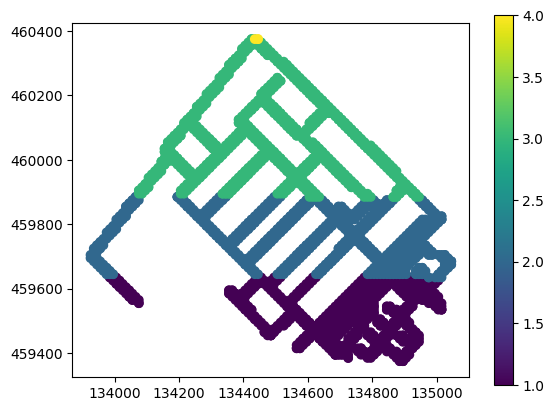

In [76]:

df[df['sub_area'] == 'Overvecht'].plot(column='fold', legend=True)

<Axes: >

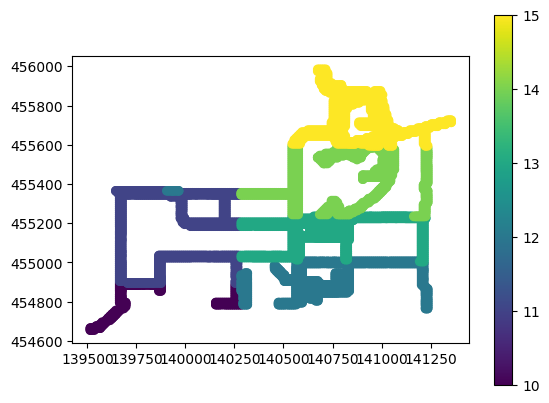

In [77]:

df[df['sub_area'] == 'Science Park'].plot(column='fold', legend=True)

<Axes: >

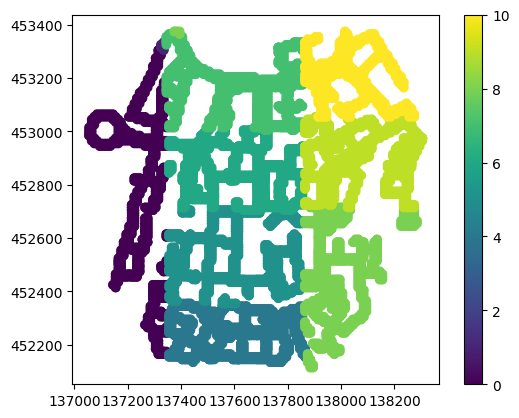

In [78]:

df[df['sub_area'] == 'Lunetten'].plot(column='fold', legend=True)

In [18]:
folds = np.array([[n]*(df.shape[0] // no_of_folds) for n in range(no_of_folds-1)] + [[no_of_folds-1]*(df.shape[0] - (df.shape[0]//no_of_folds*(no_of_folds-1)))]).flatten()
print(len(folds))

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (16,) + inhomogeneous part.

In [20]:
np.array([[n]*(df.shape[0] // no_of_folds) for n in range(no_of_folds-1)] + [[no_of_folds-1]*(df.shape[0] - (df.shape[0]//no_of_folds*(no_of_folds-1)))])

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (16,) + inhomogeneous part.